In [2]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
def _get_positions_for_unicycle(steps, velocity, angular_velocity, delta_t, noise_std=0.2):
    """
    This function computes positions and their noisy measurements of an object
    moving using a unicycle model.
    For more info: http://faculty.salina.k-state.edu/tim/robotics_sg/Control/kinematics/unicycle.html
    """
    positions = np.zeros((steps, 2))
    measurements = np.zeros_like(positions)
    x_i = 0
    y_i = 0
    theta_i = 0
    
    for i in range(steps):
        vel_x = velocity * np.cos(theta_i)
        vel_y = velocity * np.sin(theta_i)
        x_i += vel_x*delta_t
        y_i += vel_y*delta_t
        theta_i += angular_velocity*delta_t
        noise = np.random.normal(0, noise_std, 2)
        measurements[i, :] = np.array((x_i, y_i)) + noise
        positions[i, :] = np.array((x_i, y_i))
        
    return positions, measurements


STEPS = 200
DELTA_T_SECONDS = 0.03

VELOCITY_M_S = 3
ANGULAR_VELOCITY_RAD_S = 0.4

real_positions, y = _get_positions_for_unicycle(
    steps=STEPS,
    velocity=VELOCITY_M_S,
    angular_velocity=ANGULAR_VELOCITY_RAD_S,
    delta_t=DELTA_T_SECONDS)

In [4]:
# A and C defines the linear constant velocity model to be used for the KF.
# Since we are using a linear model f() and h() are matrices.
# A is the state transition matrix (we simplify using no input)
# x(k+1) = Ax(k)
# C is the measurement matrix
# y(k) = Cx(k)
# For more info on constant velocity models: 
# http://ais.informatik.uni-freiburg.de/teaching/ws09/robotics2/pdfs/rob2-12-tracking.pdf
A = np.array([[1, 0, 0, DELTA_T_SECONDS, 0, 0],
            [0, 1, 0, 0, DELTA_T_SECONDS, 0],
            [0, 0, 1, 0, 0, DELTA_T_SECONDS],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]])

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0]],)

# Q and R and the covariances for the model uncertainties and the measurement nois, respectively.
# By the numbers you can already see that we trust more the model (lower covariance) than the measurements.
Q = 0.005*np.eye(6)
R = 0.5*np.eye(2)

In [5]:
# Actual Linear KF implementation.
# More info: https://en.wikipedia.org/wiki/Kalman_filter
P = np.eye(6)
x = np.zeros((6, 1))
estimated_positions = np.zeros((STEPS, 2))

for i in range(STEPS):
    x = np.dot(A, x)
    P = np.dot(np.dot(A, P), np.transpose(A)) + Q
    K = np.dot(np.dot(P, np.transpose(C)), np.linalg.inv(np.dot(np.dot(C, P), np.transpose(C))+R))
    x += np.dot(K, np.reshape(y[i, :], (2, 1)) - np.dot(C, x))
    P = np.dot(np.eye(6) - np.dot(K, C), P)
    estimated_positions[i, :] = np.reshape(x[:2], (2,))

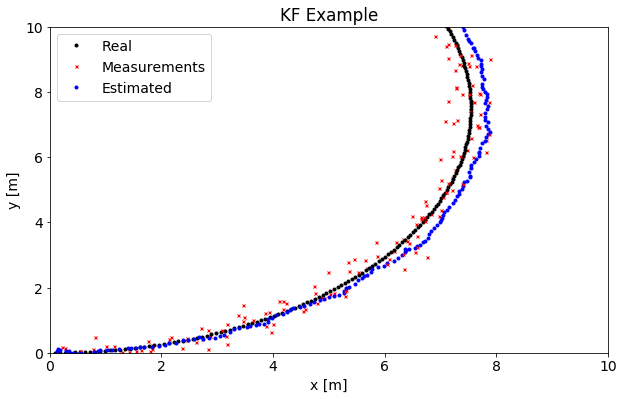

In [9]:
fig = plt.figure(figsize=(10,6))
for i in range(STEPS):
    plt.plot(real_positions[i, 0], real_positions[i, 1], "ko", ms=3, label="Real")
    plt.plot(y[i, 0], y[i, 1], "rx", ms=3, label="Measurements")
    plt.plot(estimated_positions[i, 0], estimated_positions[i, 1], "bo", ms=3, label="Estimated")
    if i == 0:
        plt.legend()
        

plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title("KF Example")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.show()